# KNN

## kd_tree node 的创建与搜索

In [1]:
import numpy as np
from typing import *
from graphviz import Digraph
import heapq
from scipy.spatial import cKDTree
from collections import Counter


class NODE:
    """ 树节点 """
    def __init__(self, point: List, idx:int, level: int, parent: 'NODE' = None, left: 'NODE' = None, right: 'NODE'=None):
        self.point = point # 数据点
        self.idx = idx # 数据点在原始数据中的索引
        self.level = level # 节点所在的层级（划分维度）
        self.parent = parent # 父节点
        self.left = left # 左子节点
        self.right = right # 右子节点

class KD_TREE:
    """ NODE 组成的 kd_tree """
    def __init__(self, X: List, Label: List, k_n: int=3):
        # 附加索引到数据点
        indexed_X = [(point, i) for i, point in enumerate(X)]
        self.root = self.__get_kd_tree(indexed_X, 0)
        self.points = X # 数据
        self.label = Label # 标签
        self.k_n = k_n
    
    ### 初始化构建 KD_tree
    def __get_kd_tree(self, indexed_X: List[tuple], level: int, parent: NODE = None) -> NODE:
        """ 构建kd tree
        X : m 维特征向量 
        level : 以第 level 维进行超平面划分
        """
        n = len(indexed_X) # 向量数
        if n==0:
            return None
        
        dim = len(indexed_X[0][0]) # 特征维数
        level = level%dim # 第level维进行划分
        indexed_X.sort(key=lambda x: x[0][level]) # 按照第level维进行排序
        mid = n//2
        root = NODE(indexed_X[mid][0],indexed_X[mid][1], level, parent) # 中值
        root.left = self.__get_kd_tree(indexed_X[:mid], level+1, root)
        root.right = self.__get_kd_tree(indexed_X[mid+1:], level+1, root)
        return root

    ### 层序遍历
    def level_travel(self) -> List:
        """ 层序遍历 """
        nn = self.root
        if nn is None:
            return None
        ans = []
        res = [nn]
        while len(res):
            tmp = []
            for node in res:
                tmp.append(node)
            ans.append([i.point for i in tmp])
            res.clear()
            for node in tmp:
                if node.left:
                    res.append(node.left)
                if node.right:
                    res.append(node.right)
        return ans

    ### 绘图
    def __add_node(self, dot, node, parent_id=None, i=0, edge_label=''):
        """ 添加节点 """
        loc = node.point
        node_id = str(i)
        dot.node(node_id, f"[{node.idx}]\n({','.join(str(i) for i in loc)})")
        if parent_id:
            dot.edge(parent_id, node_id, label=edge_label)
        if node.left:
            i = self.__add_node(dot, node.left, node_id, i + 1, f'left dim:{node.level}')
        if node.right:
            i = self.__add_node(dot, node.right, node_id, i + 1, f'right dim:{node.level}')
        return i

    def create_graph(self):
        """ 绘图 """
        dot = Digraph(comment='Kd-tree')
        dot.attr('node',
                fontsize='10',
                shape='circle',
                width='1',
                fixedsize='true')
        dot.attr('edge', arrowsize='0.7')
        self.__add_node(dot, self.root)
        return dot

    ### 获取最近的 k 个节点
    def __point_dist(self, A:List, B:List, p: float=2) ->float:
        """ 计算距离 """
        X=np.array(A)
        Y=np.array(B)
        return np.sum(np.abs(X - Y)**p)**(1 / p)

    def __bin_insert(self, dists_indexs:List, dist_index: List, k: int=1)->List:
        """ 二分插入 
        - dists_indexs: [[dis, index], [] ...]
        - dist_index: [dis, index] 
        """
        r = len(dists_indexs)
        if r==0:
            dists_indexs.append(dist_index)
            return dists_indexs
        if dist_index[0]>=dists_indexs[-1][0]:
            return dists_indexs
        l=0
        r=r-1
        while(l < r):
            mid = (l+r)//2
            if dist_index[0] > dists_indexs[mid][0]:
                l = mid + 1
            elif dist_index[0] < dists_indexs[mid][0]:
                r = mid - 1
        dists_indexs.insert(max(l,r),dist_index)
        if(len(dists_indexs)>k):
            dists_indexs.pop()
        return dists_indexs

    # BBF 优化 k-d 树搜索的算法
    def search_k_nearest_neighbors(self, target: List, k: int=None) -> List[tuple]:
        """搜索最近的 k 个节点
        - target: 目标点（待搜索的点）
        - k: 要找到的最近邻节点数
        """
        if k is None:
            k=self.k_n
            
        def search_nearest(node, target, k, heap):
            if node is None:
                return

            dist = self.__point_dist(node.point, target)
            dist_index = [dist, node.idx]

            heap = self.__bin_insert(heap, dist_index, k)

            split_dim = node.level
            if target[split_dim] < node.point[split_dim]:
                search_nearest(node.left, target, k, heap)
                if len(heap) < k or abs(target[split_dim] - node.point[split_dim]) < heap[0][0]:
                    search_nearest(node.right, target, k, heap)
            else:
                search_nearest(node.right, target, k, heap)
                if len(heap) < k or abs(target[split_dim] - node.point[split_dim]) < heap[0][0]:
                    search_nearest(node.left, target, k, heap)

        heap = []
        search_nearest(self.root, target, k, heap)

        return  [heap_item[0] for heap_item in heap], [heap_item[1] for heap_item in heap]

    def get_knn(self, target: List, k: int = None) -> List:
        """ 获取k个nn
        - target: [x0,x1,..] 一个目标点
        - k: 1  
        
        return  
        - dis: []
        - index: []

        使用实示例：
        - dis, idx = kd_tree.get_knn([5.1,7], 2)
        - for d, i in zip(dis, idx):
        - \tprint(d,i)
        """
        if k is None:
            k=self.k_n
            
        kd_tree = cKDTree(self.points)
        return kd_tree.query(target, k)
    
    # 获取预测标签
    def get_predict_accu_label(self, X_test: List, k: int=None)->int:
        """ X_test: [[1,1],[1,3],[]...] """
        if k is None:
            k=self.k_n
            
        accu = []
        label = []
        for x in X_test:
            _, indexs = self.get_knn(x, k)
            if k!=1:
                labs = [self.label[i] for i in indexs]    
                lab, times = Counter(labs).most_common(1)[0]
                label.append(lab)
                accu.append(times/len(indexs))
            else:
                label.append(self.label[indexs])
                accu.append(1.00)
        return accu, label
        

## kd_tree 的使用测试

### kd_tree 的创建

[7, 2]
5


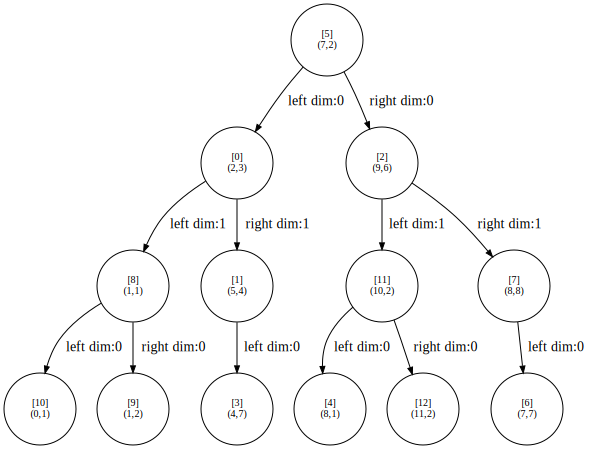

In [2]:
points = [[2, 3], [5, 4], [9, 6], [4, 7], [8, 1], [7, 2], [7,7],[8,8],[1,1],[1,2],[0,1],[10,2],[11,2]]
label = [0,1,1,1,1,1,1,1,0,0,0,1,1]

kd_tree = KD_TREE(points,label)
print(kd_tree.root.left.parent.point)
print(kd_tree.root.idx)
kd_tree.create_graph()

### knn 的搜索

In [3]:
nearest_neighbors = kd_tree.search_k_nearest_neighbors([2,4.5], 4)
print(nearest_neighbors)
ans = kd_tree.get_knn([2,4.5], 4)
print(ans)


([1.5, 3.0413812651491097, 3.2015621187164243, 5.5901699437494745], [0, 1, 3, 5])
(array([1.5       , 2.6925824 , 3.04138127, 3.20156212]), array([0, 9, 1, 3]))


In [4]:
kd_tree.get_predict_accu_label([[8,2], [1,1], [3,3]])

([1.0, 1.0, 0.6666666666666666], [1, 0, 0])

### 随机数据生成

In [5]:
from time import process_time
from random import random

import random

def random_points_labels(dimensions, N):
    """生成N个随机点，每个点有指定维度，并且坐标值在[0, 100]之间
    :param dimensions: 点的维度
    :param N: 需要生成的随机点数量
    :return: 一个包含随机点的列表
    """
    points = []
    labels = []
    for _ in range(N):
        point = [random.randint(0, 100) for _ in range(dimensions)]
        points.append(point)
        label = random.randint(0,dimensions-1)
        labels.append(label)

    return points, labels

# 生成包含10个三维随机点的列表
N = 20
points, labels = random_points_labels(3, N)
print(points[0:10])
print(labels[0:10])


[[37, 62, 42], [90, 2, 52], [22, 23, 29], [75, 26, 53], [76, 14, 57], [44, 61, 61], [53, 55, 69], [73, 56, 12], [63, 9, 26], [79, 19, 34]]
[0, 0, 0, 1, 2, 0, 1, 1, 1, 0]


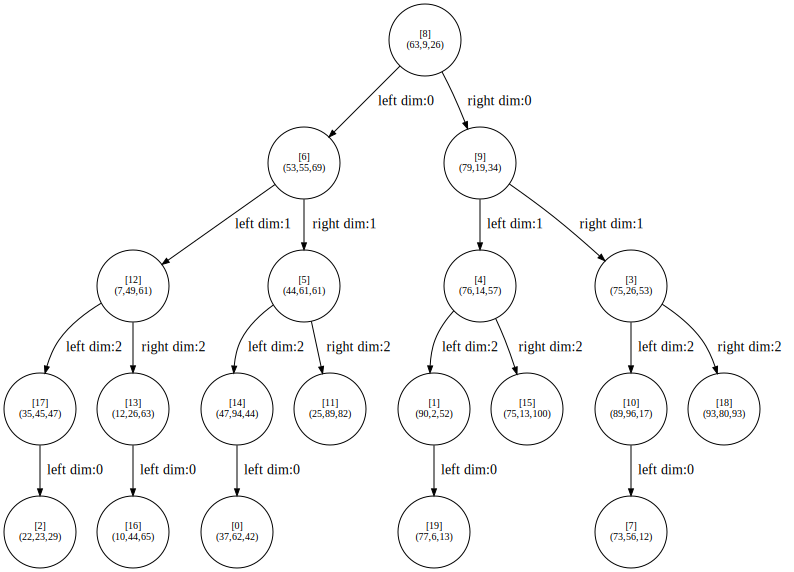

In [6]:
kd = KD_TREE(points, labels)
kd.create_graph()

## 交叉验证类的创建

In [7]:
import random
import statistics
from copy import deepcopy
class KNN_CROSS_VALIDATION:
    def __init__(self, kd_tree: KD_TREE, k_fold: int=5):
        self.kd_tree = kd_tree # kd_tree
        self.k_fold=k_fold # k-fold
        self.k_n = kd_tree.k_n
        self.folds=[]
        self.mean_accu, self.stdev = self.__get_knn_accuracy(k_fold)

    def __get_knn_accuracy(self, k_fold: int=None):
        """ 
        k_fold: fold_nums 
        k: knn
        """
        if k_fold is None:
            k_fold = self.k_fold
        k=self.k_n

        n = len(self.kd_tree.points)
        points = deepcopy(self.kd_tree.points)
        random.shuffle(points) # 随机打乱
        step = n//k_fold
        splitted_points = [points[i: i+step] for i in range(0, n, step)] # 互斥划分
        del points

        # 每折的均值
        for sp_point in splitted_points:
            accu, _ = self.kd_tree.get_predict_accu_label(sp_point, k)
            mean = statistics.mean(accu)
            self.folds.append(mean)

        mean = statistics.mean(self.folds)
        stdev = statistics.stdev(self.folds)
        return mean, stdev



1. 自己的交叉验证

In [8]:
kd_tree = KD_TREE(points, labels, 1)

kcv = KNN_CROSS_VALIDATION(kd_tree, 5)
print(kcv.mean_accu)
print(kcv.stdev)
for i, acc in enumerate(kcv.folds, 1):
    print(f"fold: {i},acc: {acc}")
    

1.0
0.0
fold: 1,acc: 1.0
fold: 2,acc: 1.0
fold: 3,acc: 1.0
fold: 4,acc: 1.0
fold: 5,acc: 1.0


2. scklearn 的交叉验证

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# 训练数据
X = np.array(points)
y = np.array(labels)


# 创建KNN模型
knn = KNeighborsClassifier(n_neighbors=1)

# 使用交叉验证来评估模型性能
scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')

# 打印每折的验证准确率
for fold, score in enumerate(scores, 1):
    print(f"Fold {fold}: {score}")



Fold 1: 0.25
Fold 2: 0.5
Fold 3: 0.5
Fold 4: 0.5
Fold 5: 0.25


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

# 训练数据
po = np.array(points)
la = np.array(labels)

# 创建KNN模型
knn = KNeighborsClassifier(n_neighbors=1)

# 创建一个 KFold 对象，将数据集分成 5 份
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 使用 cross_val_score 函数进行交叉验证
scores = cross_val_score(knn, po, la, cv=kf, scoring='accuracy')

# 输出结果
print("交叉验证准确率: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


交叉验证准确率: 0.20 (+/- 0.37)


## 绘制图像

In [11]:
# -*- coding: utf-8 -*-

import numpy as np
from matplotlib.font_manager import FontProperties
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def fileMatrix(filename):
    """ 数据读取与转换 """
    fr = open(filename)
    arrayOLines = fr.readlines()
    numberOfLines = len(arrayOLines)
    #返回的NumPy矩阵,解析完成的数据:numberOfLines行,3列
    returnMat = np.zeros((numberOfLines,3))
    #返回的分类标签向量
    classLabelVector = []
    #行的索引值
    index = 0
    for line in arrayOLines:
        line = line.strip()
        listFromLine = line.split('\t')
        returnMat[index,:] = listFromLine[0:3]
        #根据文本中标记的喜欢程度进行分类,1代表不喜欢,2代表魅力一般,3代表极具魅力
        if listFromLine[-1] == 'didntLike':
            classLabelVector.append(1)
        elif listFromLine[-1] == 'smallDoses':
            classLabelVector.append(2)
        elif listFromLine[-1] == 'largeDoses':
            classLabelVector.append(3)
        index += 1
    return returnMat, classLabelVector


def showdatas(datingDataMat, datingLabels):
    """ 数据的二维图表显示 """
    # 设置汉字格式
    # 将fig画布分隔成1行1列,不共享x轴和y轴,fig画布的大小为(13,8)
    # 当nrow=2,nclos=2时,代表fig画布被分为四个区域,axs[0][0]表示第一行第一个区域
    fig, axs = plt.subplots(nrows=2, ncols=2,sharex=False,
                            sharey=False, figsize=(13,8))
    numberOfLabels = len(datingLabels)
    LabelsColors = []
    for i in datingLabels:
        if i == 1:
            LabelsColors.append('red')
        if i == 2:
            LabelsColors.append('green')
        if i == 3:
            LabelsColors.append('blue')
    # 画出散点图,以datingDataMat矩阵的第一(飞行常客例程)、
    # 第二列(玩游戏)数据画散点数据,散点大小为15,透明度为0.5
    axs[0][0].scatter(x=datingDataMat[:,0], y=datingDataMat[:,1], color=LabelsColors,s=15, alpha=.5)
    # 设置标题,x轴label,y轴label
    axs0_title_text = axs[0][0].set_title(u'Flyer Miles Per Year Compared To Playing Video Games')
    axs0_xlabel_text = axs[0][0].set_xlabel(u'Flyer Miles Earned Each Year')
    axs0_ylabel_text = axs[0][0].set_ylabel(u'Time Spent Playing Video Games')
    plt.setp(axs0_title_text, size=10, weight='bold', color='red')
    plt.setp(axs0_xlabel_text, size=10, weight='bold', color='black')
    plt.setp(axs0_ylabel_text, size=10, weight='bold', color='black')
    # 画出散点图,以datingDataMat矩阵的第一(飞行常客例程)、
    # 第三列(冰激凌)数据画散点数据,散点大小为15,透明度为0.5
    axs[0][1].scatter(x=datingDataMat[:,0], y=datingDataMat[:,2], color=LabelsColors,s=15, alpha=.5)
    # 设置标题,x轴label,y轴label
    axs1_title_text = axs[0][1].set_title(u'Flyer Miles Per Year And Ice Cream Per Week')
    axs1_xlabel_text = axs[0][1].set_xlabel(u'Flyer Miles Earned Each Year')
    axs1_ylabel_text = axs[0][1].set_ylabel(u'Ice Cream Consumed Per Week')
    plt.setp(axs1_title_text, size=10, weight='bold', color='red')
    plt.setp(axs1_xlabel_text, size=10, weight='bold', color='black')
    plt.setp(axs1_ylabel_text, size=10, weight='bold', color='black')
    # 画出散点图,以datingDataMat矩阵的第二(玩游戏)、
    # 第三列(冰激凌)数据画散点数据,散点大小为15,透明度为0.5
    axs[1][0].scatter(x=datingDataMat[:,1], y=datingDataMat[:,2], color=LabelsColors,s=15, alpha=.5)
    # 设置标题,x轴label,y轴label
    axs2_title_text = axs[1][0].set_title( u'Percentage Of Playing Video Games And Ice Cream Consumed Per Week')
    axs2_xlabel_text = axs[1][0].set_xlabel( u'Percentage Of Time Spent Playing Video Games')
    axs2_ylabel_text = axs[1][0].set_ylabel( u'Litres Of Ice Cream Consumed Per Week')
    plt.setp(axs2_title_text, size=10, weight='bold', color='red')
    plt.setp(axs2_xlabel_text, size=10, weight='bold', color='black')
    plt.setp(axs2_ylabel_text, size=10, weight='bold', color='black')
    # 设置图例
    didntLike = mlines.Line2D([], [], color='red', marker='.', markersize=6, label='didntLike')
    smallDoses = mlines.Line2D([], [], color='green', marker='.', markersize=6, label='smallDoses')
    largeDoses = mlines.Line2D([], [], color='blue', marker='.', markersize=6, label='largeDoses')
    # 添加图例
    axs[0][0].legend(handles=[didntLike,smallDoses,largeDoses])
    axs[0][1].legend(handles=[didntLike,smallDoses,largeDoses])
    axs[1][0].legend(handles=[didntLike,smallDoses,largeDoses])
    # 调整子图间距
    plt.subplots_adjust(wspace =0.2, hspace =0.4)
    # 显示图片
    plt.show()



def show_dim3(data, labels):
    """ 三维图像 """
    # 特征归一化
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # 建立三维坐标系并绘制空间散点图
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colors = {1: 'red', 2: 'green', 3: 'blue'}
    likes = {
        1: "didntLike",
        2: "smallDoses",
        3: "largeDoses"
    }

    for label in np.unique(labels):
        indices = np.where(labels == label)
        ax.scatter(scaled_data[indices, 0], scaled_data[indices, 1], scaled_data[indices, 2], color=colors[label], 
        
        label=str(likes[label]))

    ax.set_xlabel('Flyer Miles')
    ax.set_ylabel('Play games')
    ax.set_zlabel('Ice-cream')

    # 显示图例
    ax.legend()
    plt.show()


读取和绘制

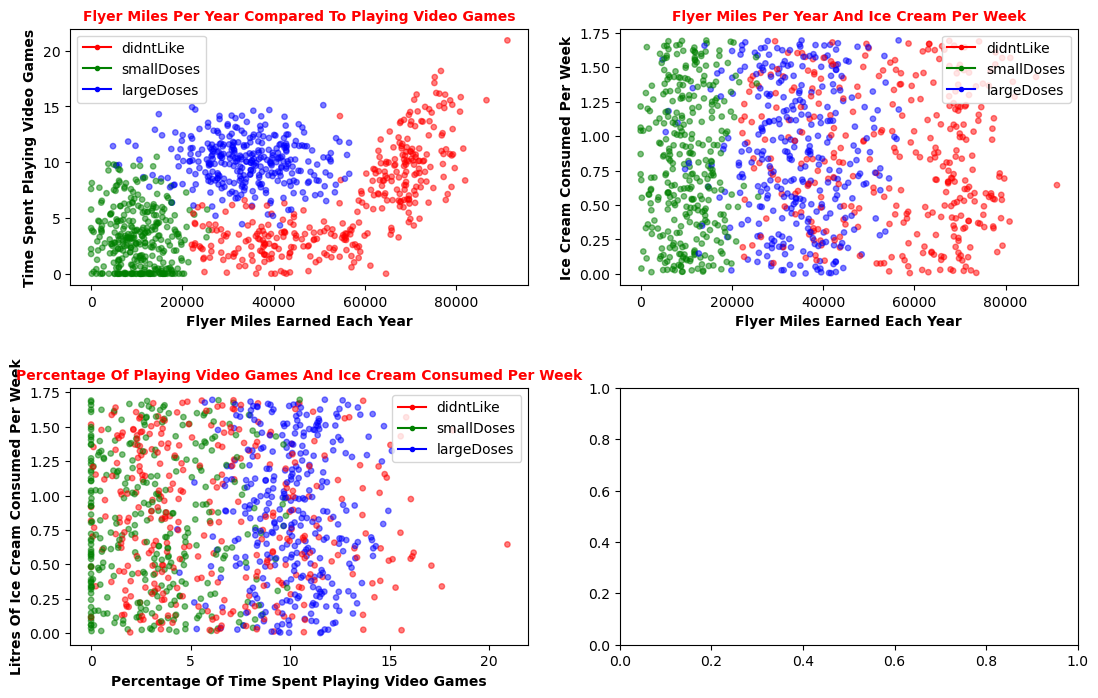

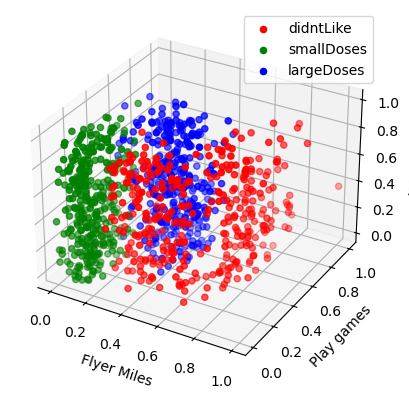

In [12]:
# 打开的文件名
filename = "datingTestSet.txt"
# 打开并处理数据
datas, labels = fileMatrix(filename)
# 二维图表图像
showdatas(datas, labels)
# 三维图像
show_dim3(datas, labels)


## 对 KNN 模型的交叉验证与 k_nn 的选取

分别对 k_fold 与 k_nn 选取不同的值，计算其交叉验证 accuracy 的 平均值，并绘制其图像

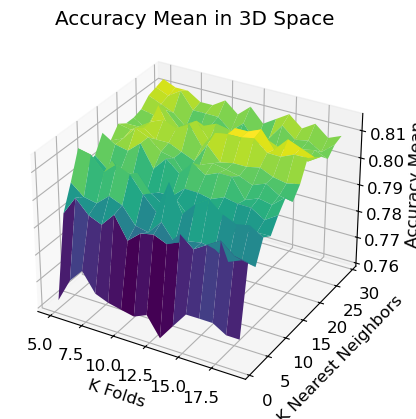

In [96]:
import numpy as np
import matplotlib.pyplot as plt

copy_datas = datas
copy_labels = labels

# 训练数据
copy_datas = np.array(copy_datas)
copy_labels = np.array(copy_labels)

k_nn_min = 1
k_nn_max = 30
k_fold_min = 5
k_fold_max = 20

k_ns = [i for i in range(k_nn_min, k_nn_max, 2)]
k_folds = [k for k in range(k_fold_min, k_fold_max)]
accus = []

for k in k_ns:
    accuracies = []
    for k_fold in k_folds:
        knn = KNeighborsClassifier(n_neighbors=k)
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
        scores = cross_val_score(knn, copy_datas, copy_labels, cv=kf, scoring='accuracy')
        accuracies.append([np.mean(scores), np.std(scores)])
    accus.append(accuracies)


# 创建 3D 图表
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 创建网格
X, Y = np.meshgrid(k_folds, k_ns)

# 提取准确度均值数据
Z = np.array([[item[0] for item in row] for row in accus])

# 绘制三维曲面图
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# 添加轴标签和标题
ax.set_xlabel('K Folds')
ax.set_ylabel('K Nearest Neighbors')
ax.set_zlabel('Accuracy Mean')
ax.set_title('Accuracy Mean in 3D Space')

# 显示图表
plt.show()

当 k_folds 为 10 时计算其 最佳的 k_nn

In [101]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV  #通过网络方式来获取参数


copy_datas = datas
copy_labels = labels

parameters={'n_neighbors':[i for i in range(1,50,2)]}
knn=KNeighborsClassifier()

# 通过GridSearchCV来搜索最好的K值
clf=GridSearchCV(knn,parameters,cv=10)  #5折
clf.fit(copy_datas,copy_labels)

# 输出最好的参数以及对应的准确率
print("最终最佳准确率：%.2f"%clf.best_score_,"最终的最佳K值",clf.best_params_)

最终最佳准确率：0.82 最终的最佳K值 {'n_neighbors': 17}


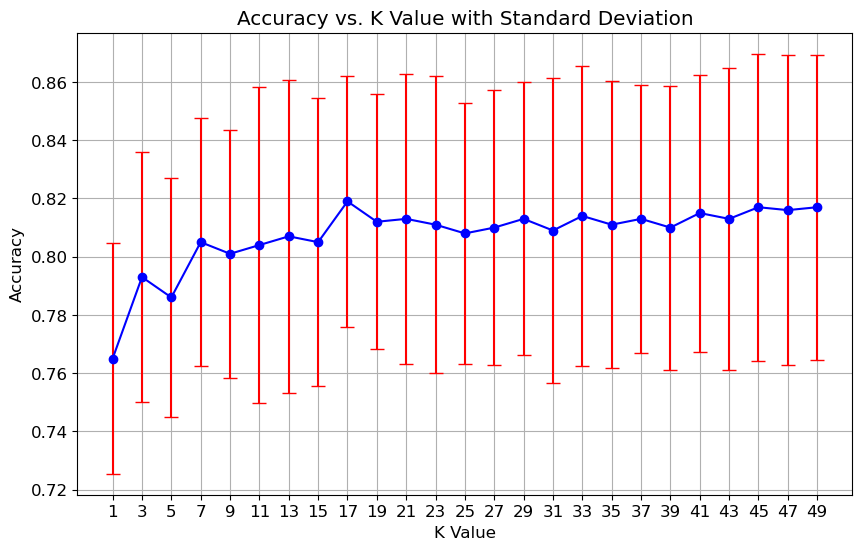

In [103]:
import matplotlib.pyplot as plt

# 获取K值、准确率和标准差
k_values = [i for i in range(1, 50, 2)]
accuracy_values = clf.cv_results_['mean_test_score']
std_deviation_values = clf.cv_results_['std_test_score']

# 绘制准确率与不同K值的图表（包含标准差）
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, accuracy_values, yerr=std_deviation_values, fmt='-o', color='b', ecolor='r', capsize=5)
plt.title('Accuracy vs. K Value with Standard Deviation')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()
